In [1]:
#we are going to import the geracao dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import os

In [2]:
dataset = pd.read_csv('data.csv')
#del dataset["Unnamed: 0"]
#print(dataset.head)

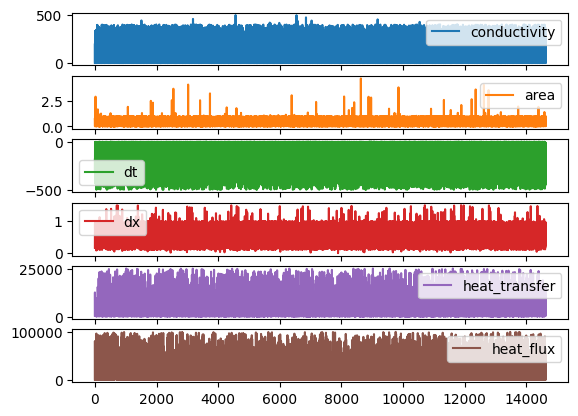

In [3]:
#we are going to plot every single data in the dataset to see how it looks like
dataset.plot(subplots=True)
plt.show()
#saving the plot as a image

In [4]:
#our y or target will be the heat_flx
target = dataset["heat_flux"]
#our x or features will be the rest of the dataset
dados = dataset[["conductivity","area","dt","dx","heat_transfer"]]

In [5]:
print(dados)

       conductivity      area          dt        dx  heat_transfer
0          0.525615  0.691083 -184.822374  0.173716     386.468575
1        201.514526  0.155258 -305.309815  0.762207   12532.206810
2         96.289947  0.014862 -289.996180  0.927244     447.551718
3          2.559100  0.826444 -242.205884  0.318195    1609.874250
4          2.797999  0.646719 -179.302858  0.907264     357.615731
...             ...       ...         ...       ...            ...
14630    126.076853  0.021518 -168.590305  0.484025     944.938359
14631     16.098813  0.849364 -125.832761  0.861347    1997.574354
14632      0.543434  0.988339 -447.132295  0.658441     364.730349
14633      1.672963  0.803805 -268.311137  0.370113     974.857945
14634     14.465555  0.163344 -231.175077  0.251720    2170.007286

[14635 rows x 5 columns]


In [6]:
print(target)

0          559.221314
1        80718.657747
2        30114.746830
3         1947.952868
4          552.969015
             ...     
14630    43913.697804
14631     2351.848099
14632      369.033737
14633     1212.803587
14634    13284.927521
Name: heat_flux, Length: 14635, dtype: float64


In [7]:
target = np.array(target)
dados = np.array(dados)

In [8]:
print(dados)

[[ 5.25615034e-01  6.91083415e-01 -1.84822374e+02  1.73715515e-01
   3.86468575e+02]
 [ 2.01514526e+02  1.55257869e-01 -3.05309815e+02  7.62207454e-01
   1.25322068e+04]
 [ 9.62899470e+01  1.48615468e-02 -2.89996180e+02  9.27243950e-01
   4.47551718e+02]
 ...
 [ 5.43433873e-01  9.88338767e-01 -4.47132295e+02  6.58440707e-01
   3.64730349e+02]
 [ 1.67296333e+00  8.03805295e-01 -2.68311137e+02  3.70113262e-01
   9.74857945e+02]
 [ 1.44655547e+01  1.63343555e-01 -2.31175077e+02  2.51719530e-01
   2.17000729e+03]]


In [9]:
#scaling both the target and the features, keep in mind that we can reverse the scaling later
scaler = StandardScaler()
dados = scaler.fit_transform(dados)
target = scaler.fit_transform(target.reshape(-1,1))

In [10]:
X_train_full, x_test, y_train_full, y_test = train_test_split(dados, target, test_size=0.25, random_state=42)


In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [12]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3,activation="tanh", input_shape=[5]):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation=activation, **options))
        options = {}
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [13]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

C:\Users\lucca\AppData\Local\Temp\ipykernel_11124\1709004121.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [14]:
param_distribs = {
    "n_hidden": [0, 1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    "n_neurons": np.arange(10, 256),
    "learning_rate": reciprocal(3e-5, 3e-3),
    "activation": ["tanh"],
}

In [15]:
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=5,n_jobs=1,cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid),
                    callbacks=[keras.callbacks.EarlyStopping(patience=5,monitor="val_loss")],verbose=2)

Epoch 1/50


c:\Users\lucca\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


172/172 - 2s - loss: 0.5045 - val_loss: 0.4405 - 2s/epoch - 12ms/step
Epoch 2/50
172/172 - 1s - loss: 0.4187 - val_loss: 0.4283 - 811ms/epoch - 5ms/step
Epoch 3/50
172/172 - 1s - loss: 0.4119 - val_loss: 0.4232 - 916ms/epoch - 5ms/step
Epoch 4/50
172/172 - 1s - loss: 0.4061 - val_loss: 0.4196 - 922ms/epoch - 5ms/step
Epoch 5/50
172/172 - 1s - loss: 0.4015 - val_loss: 0.4125 - 954ms/epoch - 6ms/step
Epoch 6/50
172/172 - 1s - loss: 0.3958 - val_loss: 0.4059 - 924ms/epoch - 5ms/step
Epoch 7/50
172/172 - 1s - loss: 0.3893 - val_loss: 0.3992 - 891ms/epoch - 5ms/step
Epoch 8/50
172/172 - 1s - loss: 0.3827 - val_loss: 0.3906 - 982ms/epoch - 6ms/step
Epoch 9/50
172/172 - 1s - loss: 0.3741 - val_loss: 0.3819 - 892ms/epoch - 5ms/step
Epoch 10/50
172/172 - 1s - loss: 0.3647 - val_loss: 0.3712 - 779ms/epoch - 5ms/step
Epoch 11/50
172/172 - 1s - loss: 0.3536 - val_loss: 0.3585 - 763ms/epoch - 4ms/step
Epoch 12/50
172/172 - 1s - loss: 0.3404 - val_loss: 0.3429 - 740ms/epoch - 4ms/step
Epoch 13/50
17

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000002B7230D6CE0>,
                   n_iter=5, n_jobs=1,
                   param_distributions={'activation': ['tanh'],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002B74DC42E90>,
                                        'n_hidden': [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                     9, 10, 11, 12, 13, 14, 15,
                                                     16, 17, 18, 19, 20],
                                        'n_neurons': array([...
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
       231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
       244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255])})

In [16]:
model = rnd_search_cv.best_estimator_.model

In [17]:
hist = model.history.history

In [18]:
rnd_search_cv.best_params_

{'activation': 'tanh',
 'learning_rate': 0.0022991030169481567,
 'n_hidden': 12,
 'n_neurons': 112}

In [19]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_180 (Dense)           (None, 112)               672       
                                                                 
 dense_181 (Dense)           (None, 112)               12656     
                                                                 
 dense_182 (Dense)           (None, 112)               12656     
                                                                 
 dense_183 (Dense)           (None, 112)               12656     
                                                                 
 dense_184 (Dense)           (None, 112)               12656     
                                                                 
 dense_185 (Dense)           (None, 112)               12656     
                                                                 
 dense_186 (Dense)           (None, 112)             

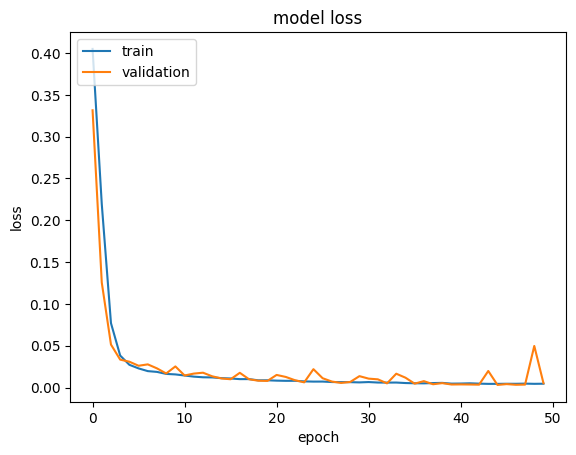

In [20]:
#ploting the loss and the validation loss
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()


In [21]:
mse_test = model.evaluate(x_test, y_test) #mse

115/115 [==============================] - 0s 1ms/step - loss: 0.0058


In [22]:
y_pred = model.predict(x_test)
y_pred = y_pred.flatten()

115/115 [==============================] - 0s 1ms/step


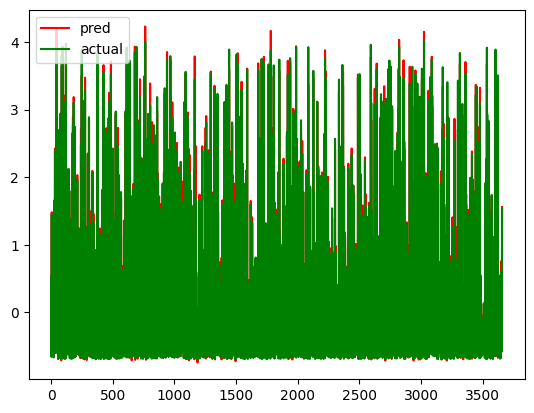

In [23]:
#we have to convert the y_test back to its original shape
#we are going to inverse the scaling of the y_pred, since we scaled it before
#inverse scaling both the y_pred and the y_test
#y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
#y_test = scaler.inverse_transform(y_test.reshape(-1,1))

plt.plot(y_pred, color="red", label="pred")
plt.plot(y_test, color="green", label="actual")
plt.legend(loc="upper left")
plt.show()

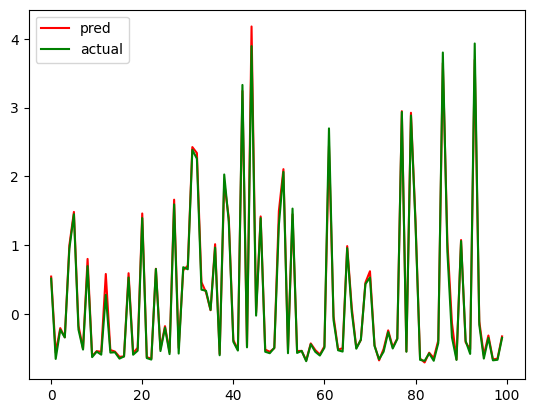

In [24]:
#plotting just the first 100 predictions and values
plt.plot(y_pred[:100], color="red", label="pred")
plt.plot(y_test[:100], color="green", label="actual")
plt.legend(loc="upper left")
plt.show()


In [25]:
mean_squared_error(y_test, y_pred)

0.005830537509054564

In [26]:
#showing the predictions of the first 10 values 
y_pred_inversed = scaler.inverse_transform(y_pred.reshape(-1,1))
y_test_inversed = scaler.inverse_transform(y_test.reshape(-1,1))
for i in range(10):
    print("pred: ", y_pred_inversed[i], "actual: ", y_test_inversed[i])


pred:  [26140.822] actual:  [25527.33048214]
pred:  [2662.1616] actual:  [724.47760525]
pred:  [10234.737] actual:  [9756.4885293]
pred:  [7395.008] actual:  [7357.30445269]
pred:  [35772.703] actual:  [34724.4621427]
pred:  [46093.93] actual:  [45384.0845165]
pred:  [11010.828] actual:  [9785.82387072]
pred:  [3838.9673] actual:  [3610.68411376]
pred:  [31588.496] actual:  [29374.93715427]
pred:  [1603.0288] actual:  [1276.16730176]


In [27]:
dataset_test = pd.read_csv('teste.csv')

In [28]:
#setting up the target and the data
target = dataset_test["heat_flux"]
dados = dataset_test[['conductivity','area','dt','dx','heat_transfer']]
#scaling the data
scaler = StandardScaler()
dados = scaler.fit_transform(dados)
target = target.values.reshape(-1,1)
target = scaler.fit_transform(target)


In [29]:
new_mse_test = model.evaluate(dados, target)

183/183 [==============================] - 0s 1ms/step - loss: 0.0058


In [30]:
#getting the path of every single file that eds with .h5 in the folder
path = os.getcwd()
files = os.listdir(path)
files = [f for f in files if f.endswith(".h5")]

#a partir da linha de cima, teremos uma lista com todos os modelos já salvos na psta

In [31]:
print(files)

['model_14_222_2884.h5', 'model_15_25_7359.h5', 'model_19_81_58224.h5']


In [32]:
#com a linha abaixo iremos obter duas listas, cada uma delas contendo as evaluations de cada modelo previamente salvo,
#para que podemos plotar o gráfico de loss e val_loss geral mais tarde.
mse_list_test = []
mse_list_new_test = []
for i in files:
    print(i)
    model = keras.models.load_model(i)

    mse_list_new_test.append( model.evaluate(dados, target))

    mse_list_test.append(model.evaluate(x_test, y_test))

model_14_222_2884.h5
115/115 [==============================] - 0s 2ms/step - loss: 0.0288
model_15_25_7359.h5
115/115 [==============================] - 0s 2ms/step - loss: 0.0288
model_19_81_58224.h5
115/115 [==============================] - 0s 3ms/step - loss: 0.0288


In [33]:
#average of the evaluations of older models on the test set
average_mse_test = np.average(mse_list_test)
#average o the new evaluations on the test set
average_mse_new_test = np.average(mse_list_new_test)

In [34]:
print("average mse test: ", average_mse_test)
print("average mse new test: ", average_mse_new_test)

average mse test:  0.02882062830030918
average mse new test:  0.023125916719436646


In [35]:
print("mse test: ", mse_test)
print("mse new test: ", new_mse_test)

mse test:  0.005830537993460894
mse new test:  0.00582316005602479


In [36]:
#the name of the model will include its amount of hidden layers, its amount of neurons and the amount of indexes in the dataset
#that were used to train it
amount = len(dataset)

name = "model_" + str(rnd_search_cv.best_params_["n_hidden"]) + "_" + str(rnd_search_cv.best_params_["n_neurons"]) +  "_"+ str(amount) + ".h5"
model.save(name)
print("model saved")

model saved


In [37]:
#showing the first 10 predctions and the real values
y_pred = model.predict(dados)
y_pred = y_pred.flatten()

for i in range(10):
    print("pred: ", y_pred[i], "actual: ", target[i])

183/183 [==============================] - 1s 2ms/step
pred:  0.030767865 actual:  [0.14383479]
pred:  2.97178 actual:  [2.89159149]
pred:  0.27788445 actual:  [0.25664841]
pred:  -0.4601173 actual:  [-0.49293873]
pred:  -0.44290403 actual:  [-0.37382883]
pred:  -0.48527023 actual:  [-0.48579226]
pred:  2.6330185 actual:  [2.38314304]
pred:  -0.6416743 actual:  [-0.66977091]
pred:  3.2602105 actual:  [3.56344185]
pred:  -0.6615525 actual:  [-0.59773474]


In [38]:
#Plotting the predictions and the real values
y_pred_inversed = scaler.inverse_transform(y_pred.reshape(-1,1))
target_inversed = scaler.inverse_transform(target.reshape(-1,1))

for i in range(10):
    print("pred: ", y_pred_inversed[i], "actual: ", target_inversed[i])

pred:  [14940.402] actual:  [17289.7404454]
pred:  [76049.63] actual:  [74383.45005907]
pred:  [20075.064] actual:  [19633.81567118]
pred:  [4740.643] actual:  [4058.67008021]
pred:  [5098.306] actual:  [6533.57116779]
pred:  [4218.0083] actual:  [4207.16164069]
pred:  [69010.74] actual:  [63818.75641276]
pred:  [968.19885] actual:  [384.39827572]
pred:  [82042.73] actual:  [88343.35752408]
pred:  [555.1627] actual:  [1881.18725312]


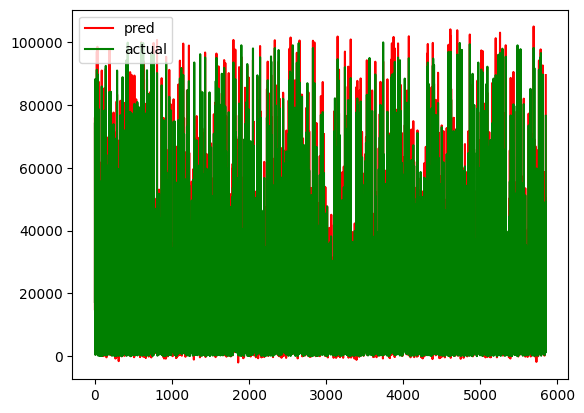

In [39]:
plt.plot(y_pred_inversed, color="red", label="pred")
plt.plot(target_inversed, color="green", label="actual")
plt.legend(loc="upper left")
plt.show()